# MultiSensor Dataset Preparation 
- Experiment data: March 2024. Aluminum, Laser-Wire DED
- Aurthor: Chen Lequn

### Notebook 1: Video Segmentation, Audio signal extraction, Annotation Data Loading

In [1]:
## Required python libraries
import pandas as pd
import numpy as np
import scipy as sp
import scipy.signal
import os
import math
import sys
from scipy.interpolate import griddata

# to make this notebook's output stable across runs
np.random.seed(42)

pd.plotting.register_matplotlib_converters()


import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline
import seaborn as sns
import librosa
import matplotlib.font_manager as font_manager

#---------------opencv------------------------
import cv2
from IPython.display import Image, display

In [2]:
import scaleogram as scg 
from glob import glob
import scipy
from scipy.signal import welch
import wave                    # library handles the parsing of WAV file headers
import pywt
import soundfile as sf
import glob
import re
from tqdm.notebook import tqdm
import numpy as np
import torch
from PIL import Image

In [3]:
# ------------------- plotly visualizatoin----------------------------------
# from PIL import Image
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from skimage import data

from glob import glob
import glob
import scipy
from scipy.signal import welch
import wave                    # library handles the parsing of WAV file headers
import pywt
import soundfile as sf
import matplotlib.font_manager as font_manager

In [4]:
## Audio signal processing libraries
import librosa
import librosa.display

import IPython.display as ipd
import plotly.express as px
import plotly.io as pio
# import nussl
import natsort

In [5]:
from moviepy.editor import VideoFileClip
import imageio_ffmpeg as ffmpeg
from tqdm.notebook import tqdm

In [6]:
# Where to save the figures, and dataset locations
PROJECT_ROOT_DIR = "../"

# Change to desirable location of the raw dataset
Multimodal_dataset_PATH = "/home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset"

segmented_video_folder = os.path.join(Multimodal_dataset_PATH, 'segmented_videos')
segmented_audio_path = os.path.join(Multimodal_dataset_PATH, 'segmented_audio')
Video_path = os.path.join(Multimodal_dataset_PATH, 'Raw_Video', "Aluminium", 'avi')
Audio_path = os.path.join(Multimodal_dataset_PATH, 'Audio')
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'pre-processing')

final_audio_dataset = os.path.join(Multimodal_dataset_PATH, 'Dataset', "audio")
final_image_dataset = os.path.join(Multimodal_dataset_PATH, 'Dataset', "thermal_images")

os.makedirs(IMAGE_PATH, exist_ok=True)
os.makedirs(segmented_video_folder, exist_ok=True)
os.makedirs(segmented_audio_path, exist_ok=True)
os.makedirs(Audio_path, exist_ok=True)
os.makedirs(final_audio_dataset, exist_ok=True)
os.makedirs(final_image_dataset, exist_ok=True)

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [7]:
def plot_data_distribution(data, variable, title, filename, figure_size=(7, 6)):
    # Initialize the plot
    fig, ax = plt.subplots(figsize=figure_size)
    
    # Create the countplot
    sns.countplot(x=variable, data=data, palette='Set1', saturation=0.7, edgecolor='k', linewidth=1.5, ax=ax, alpha = 0.9)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    
    # Add percentages above each bar
    total = len(data)
    max_height = 0
    for p in ax.patches:
        max_height = max(max_height, p.get_height())
        percentage = f'{100 * p.get_height() / total:.1f}%'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='bottom')
    
    # Extend the y-axis for better visibility of annotations
    ax.set_ylim([0, max_height * 1.2])
    
    # Set labels and title
    ax.set_title(title, fontsize=18, pad=14)
    ax.set_xlabel("Categories", fontsize=20, labelpad=12)
    ax.set_ylabel("Data volume", fontsize=20, labelpad=10)
    ax.tick_params(labelsize=15)
    
    # Add grid
    ax.grid(True, which='both', axis='y', linestyle='dotted', linewidth=0.5, alpha=0.7, color='black')
    
    # Show all four edges of the plot
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    
    # Show the plot
    plt.tight_layout()
    save_fig(f"{filename}")
    plt.show()

In [8]:
sys.path.insert(0, './utils')

from utils_functions import *

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    
/bin/sh: 1: sox: not found
2024-05-24 12:08:00.381347: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-24 12:08:00.401689: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 12:08:00.726333: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Read raw annotation file generated from label-studio

In [9]:
# Load the annotation CSV file
annotation_path = os.path.join(Multimodal_dataset_PATH, 'Annotation', 'annotation.csv')
annotations = pd.read_csv(annotation_path)

# Display the first few rows to understand its structure, especially the "tricks" column and the video file name column
annotations.head()

,annotation_id,annotator,created_at,id,lead_time,tricks,updated_at,video_url
0,1,1,2024-04-06T05:53:57.952476Z,1,951.570,"[{""start"":0.13643146951251442,""end"":2.23151717...",2024-04-06T05:54:02.688695Z,/data/upload/1/d08b69d0-Exp_25.mp4
1,2,1,2024-04-06T06:19:31.940332Z,2,226.184,"[{""start"":1.861716122872687,""end"":3.5466838501...",2024-05-24T02:47:39.674555Z,/data/upload/1/f123370e-Exp_April_16_test.mp4
2,3,1,2024-04-06T07:28:18.531736Z,3,1032.868,"[{""start"":1.590334275965151,""end"":4.4448258297...",2024-05-24T02:50:25.371054Z,/data/upload/1/f3a38ee1-Exp_24.mp4
3,4,1,2024-04-06T07:49:02.470237Z,4,947.742,"[{""start"":1.3547890103644464,""end"":3.843715907...",2024-05-24T02:52:22.407017Z,/data/upload/1/f3bfc771-Exp_19.mp4
4,5,1,2024-04-06T08:28:43.140531Z,5,1412.740,"[{""start"":4.076867618221584,""end"":5.2923102035...",2024-04-06T08:28:44.786510Z,/data/upload/1/117cf9c6-Exp_18.mp4


The structure of the annotation CSV file includes a "tricks" column with the annotations (start time, end time, channel, labels) and a "video_url" column containing the paths to the original video files.

### Video segmentation

- **Process Video File Names**: Extract the actual names from the "video_url" column and change the file extension.
- **Process Annotations**: Decode the JSON in the "tricks" column to extract times and labels.
- **Segment Videos**: Outline the method to segment videos based on the annotations.
- **Generate New Annotation CSV**: Structure the new annotation details.

In [10]:
import json

# Process Video File Names: Extract actual names and change file extension
annotations['corrected_video_name'] = annotations['video_url'].apply(lambda x: x.split('-')[-1].replace('.mp4', '.avi'))

# Decode JSON in the "tricks" column and extract necessary information
annotations['decoded_tricks'] = annotations['tricks'].apply(json.loads)

# For demonstration, show the processed video names and a sample of the decoded tricks
annotations[['corrected_video_name', 'decoded_tricks']].head()

,corrected_video_name,decoded_tricks
0,Exp_25.avi,"[{'start': 0.13643146951251442, 'end': 2.23151..."
1,Exp_April_16_test.avi,"[{'start': 1.861716122872687, 'end': 3.5466838..."
2,Exp_24.avi,"[{'start': 1.590334275965151, 'end': 4.4448258..."
3,Exp_19.avi,"[{'start': 1.3547890103644464, 'end': 3.843715..."
4,Exp_18.avi,"[{'start': 4.076867618221584, 'end': 5.2923102..."


In [11]:
annotations

,annotation_id,annotator,created_at,id,lead_time,tricks,updated_at,video_url,corrected_video_name,decoded_tricks
0,1,1,2024-04-06T05:53:57.952476Z,1,951.570,"[{""start"":0.13643146951251442,""end"":2.23151717...",2024-04-06T05:54:02.688695Z,/data/upload/1/d08b69d0-Exp_25.mp4,Exp_25.avi,"[{'start': 0.13643146951251442, 'end': 2.23151..."
1,2,1,2024-04-06T06:19:31.940332Z,2,226.184,"[{""start"":1.861716122872687,""end"":3.5466838501...",2024-05-24T02:47:39.674555Z,/data/upload/1/f123370e-Exp_April_16_test.mp4,Exp_April_16_test.avi,"[{'start': 1.861716122872687, 'end': 3.5466838..."
2,3,1,2024-04-06T07:28:18.531736Z,3,1032.868,"[{""start"":1.590334275965151,""end"":4.4448258297...",2024-05-24T02:50:25.371054Z,/data/upload/1/f3a38ee1-Exp_24.mp4,Exp_24.avi,"[{'start': 1.590334275965151, 'end': 4.4448258..."
3,4,1,2024-04-06T07:49:02.470237Z,4,947.742,"[{""start"":1.3547890103644464,""end"":3.843715907...",2024-05-24T02:52:22.407017Z,/data/upload/1/f3bfc771-Exp_19.mp4,Exp_19.avi,"[{'start': 1.3547890103644464, 'end': 3.843715..."
4,5,1,2024-04-06T08:28:43.140531Z,5,1412.740,"[{""start"":4.076867618221584,""end"":5.2923102035...",2024-04-06T08:28:44.786510Z,/data/upload/1/117cf9c6-Exp_18.mp4,Exp_18.avi,"[{'start': 4.076867618221584, 'end': 5.2923102..."
5,6,1,2024-04-08T07:24:20.624279Z,6,981.520,"[{""start"":3.335127250685412,""end"":4.7704057978...",2024-04-08T07:24:25.033052Z,/data/upload/1/b0e3f971-Exp_23.mp4,Exp_23.avi,"[{'start': 3.335127250685412, 'end': 4.7704057..."
6,7,1,2024-04-08T07:44:28.494292Z,7,1164.429,"[{""start"":10.079907695804085,""end"":11.23742775...",2024-04-08T07:44:28.494335Z,/data/upload/1/1e6c3647-Exp_17.mp4,Exp_17.avi,"[{'start': 10.079907695804085, 'end': 11.23742..."
7,8,1,2024-04-08T10:09:06.536476Z,8,2610.963,"[{""start"":3.0633240000534805,""end"":5.906396696...",2024-04-08T10:09:12.773727Z,/data/upload/1/2d10c30a-Exp_10.mp4,Exp_10.avi,"[{'start': 3.0633240000534805, 'end': 5.906396..."
8,9,1,2024-04-09T03:04:15.294172Z,9,6444.364,"[{""start"":4.112926194034195,""end"":6.6206632036...",2024-05-24T03:09:22.013089Z,/data/upload/1/cbe799a9-Exp_April_16.mp4,Exp_April_16.avi,"[{'start': 4.112926194034195, 'end': 6.6206632..."
9,11,1,2024-04-23T09:28:27.714229Z,10,12745.305,"[{""start"":6.175908334445803,""end"":7.6519987693...",2024-04-23T09:28:35.715094Z,/data/upload/1/6154881c-Exp_April_12.mp4,Exp_April_12.avi,"[{'start': 6.175908334445803, 'end': 7.6519987..."


### Segment video
For each row (video file) in the annotations DataFrame:

- Load the corresponding .avi video from the raw_video_file directory.
- For each annotation (`decoded_tricks`) in the row:
    - Segment the video from start to end times.
    - Save the segmented video to `segmented_video_folder` with a name format: `[original_video_name]_[index].avi`, where `[index]` indicates their position in the original video.

### Generating a New Annotation CSV
For each video segment:

- Labels should be extracted from each segment and split into different columns as necessary. 
- If a segment has multiple labels, each label occupies its own column.
- Duration is simply end - start time for each segment.

In [12]:
# Initialize lists to hold the new annotation data
new_annotations = []

for index, row in annotations.iterrows():
    video_name = row['corrected_video_name']

    # if video_name == 'Exp_April_14.avi':
    #     continue
    for i, trick in enumerate(row['decoded_tricks']):
        segment_name = f"{video_name.split('.avi')[0]}_{i+1}.avi"  # Constructing the new segment name
        labels = trick['labels']
        start_time = trick['start']
        end_time = trick['end']
        duration = end_time - start_time
        
        # Preparing the new annotation row with start and end times
        new_row = {
            'segment_name': segment_name,
            'start_time': start_time,
            'end_time': end_time,
            'duration': duration
        }
        
        # Adding labels to the row, handling the possibility of multiple labels
        for j, label in enumerate(labels, start=1):
            if label == 'Non-defective' and video_name in ['Exp_10.avi', 'Exp_22.avi']:
                new_row[f'label_{j}'] = 'LoF'
            elif label == 'Non-defective' and video_name in ['Exp_23.avi','Exp_24.avi','Exp_25.avi']:
                new_row[f'label_{j}'] = 'Overheating'
                
            elif label == 'Balling' and video_name in ['Exp_10.avi', 'Exp_17.avi','Exp_18.avi', 'Exp_22.avi']:
                new_row[f'label_{j}'] = 'Balling (LoF)'
            elif label == 'Balling' and video_name in ['Exp_23.avi', 'Exp_24.avi','Exp_25.avi']:
                new_row[f'label_{j}'] = 'Balling (Overheating)'
            elif label == 'Balling' and video_name in ['Exp_19.avi', "Exp_April_16_test.avi", "Exp_April_16.avi", "Exp_April_13.avi", "Exp_April_14.avi"]:
                new_row[f'label_{j}'] = 'Balling (Conduction)'

            elif label == 'Non-defective' and video_name in ['Exp_17.avi','Exp_18.avi', 'Exp_April_12.avi']:
                # Ignore 'Exp_April_12.avi' as too much. Ignore 'Exp_17.avi','Exp_18.avi' as they are not representative
                continue
            elif label == 'Laser-off' and video_name in ['Exp_April_12.avi', "Exp_April_14.avi", "Exp_10.avi", 'Exp_April_16.avi']:
                # Ignore this annotation as too much already.
                continue
            
                
            else:    
                new_row[f'label_{j}'] = label
        
        new_annotations.append(new_row)

# Creating a new DataFrame for the updated annotations
new_annotations_df = pd.DataFrame(new_annotations)

# Filling NaN values with an empty string for uniformity
# new_annotations_df.fillna('', inplace=True)

# Remove rows where 'label_1' is NaN
new_annotations_df_cleaned = new_annotations_df.dropna(subset=['label_1'])

In [13]:
# Show the structure of the new annotations DataFrame
new_annotations_df_cleaned

,segment_name,start_time,end_time,duration,label_1,label_2,label_3
0,Exp_25_1.avi,0.136431,2.231517,2.095086,Laser-off,Shielding Gas-off,NaN
1,Exp_25_2.avi,2.748486,4.163349,1.414863,Laser-off,Shielding Gas-on,NaN
2,Exp_25_3.avi,4.381021,6.149600,1.768579,Overheating,NaN,NaN
3,Exp_25_4.avi,6.285644,6.884240,0.598596,Laser-off,Shielding Gas-on,NaN
4,Exp_25_5.avi,7.047493,9.142579,2.095086,Overheating,NaN,NaN
...,...,...,...,...,...,...,...
438,Exp_22_1.avi,6.461877,7.396788,0.934912,LoF,NaN,NaN
439,Exp_22_2.avi,8.884893,9.567126,0.682233,Balling (LoF),NaN,NaN
440,Exp_22_3.avi,13.491051,14.072212,0.581161,LoF,NaN,NaN
441,Exp_22_4.avi,17.777746,18.653699,0.875953,LoF,NaN,NaN


Saving figure dataset_distribution (segments)


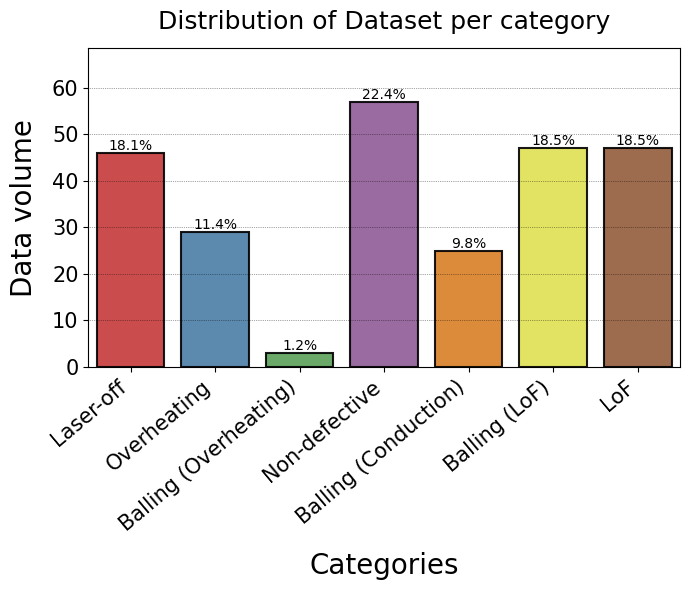

In [14]:
plot_data_distribution(new_annotations_df_cleaned, 'label_1', 
                       'Distribution of Dataset per category', 'dataset_distribution (segments)')

In [15]:
new_annotations_df_cleaned.to_csv('segment_annotations.csv', index=False)

- **Segment the Videos**: Use a script with a video processing library (like moviepy) to read each original video, segment it according to the start and end times, and save the segments with the constructed names in the segmented_video_folder.

- Save the New Annotations CSV: The prepared new_annotations_df_cleaned DataFrame should be saved as a CSV file to accompany the segmented videos.

In [16]:
# Iterate over each row in the corrected annotations DataFrame
for index, row in new_annotations_df_cleaned.iterrows():
    # Construct the path to the original video using the base name extracted from the segment name
    base_video_name_parts = row['segment_name'].split('_')[:-1]  # Removing the index part, e.g., "1.avi"
    base_video_name = '_'.join(base_video_name_parts) + '.avi'  # Re-adding the '.avi' extension
    
    original_video_path = os.path.join(Video_path, base_video_name)
    segment_path = os.path.join(segmented_video_folder, row['segment_name'])
    segmented_audio_filename = os.path.join(segmented_audio_path, row['segment_name'].replace('.avi', '.wav'))
    
    clip = VideoFileClip(original_video_path)
    segmented_clip = clip.subclip(row['start_time'], row['end_time'])
    
    segmented_clip.write_videofile(segment_path, codec='libx264')
    segmented_clip.audio.write_audiofile(segmented_audio_filename)
    
    clip.close()
    segmented_clip.close()

Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_1.avi.
MoviePy - Writing audio in Exp_25_1TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_1.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_1.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_25_1.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_2.avi.
MoviePy - Writing audio in Exp_25_2TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_2.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_2.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_25_2.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_3.avi.
MoviePy - Writing audio in Exp_25_3TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_3.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_3.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_25_3.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_4.avi.
MoviePy - Writing audio in Exp_25_4TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_4.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_4.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_25_4.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_5.avi.
MoviePy - Writing audio in Exp_25_5TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_5.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_5.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_25_5.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_6.avi.
MoviePy - Writing audio in Exp_25_6TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_6.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_6.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_25_6.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_7.avi.
MoviePy - Writing audio in Exp_25_7TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_7.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_7.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_25_7.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_8.avi.
MoviePy - Writing audio in Exp_25_8TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_8.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_8.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_25_8.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_9.avi.
MoviePy - Writing audio in Exp_25_9TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_9.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_9.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_25_9.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_10.avi.
MoviePy - Writing audio in Exp_25_10TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_10.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_10.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_25_10.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_11.avi.
MoviePy - Writing audio in Exp_25_11TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_11.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_11.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_25_11.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_12.avi.
MoviePy - Writing audio in Exp_25_12TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_12.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_12.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_25_12.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_13.avi.
MoviePy - Writing audio in Exp_25_13TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_13.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_25_13.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_25_13.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_test_1.avi.
MoviePy - Writing audio in Exp_April_16_test_1TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_test_1.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_test_1.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_test_1.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_test_2.avi.
MoviePy - Writing audio in Exp_April_16_test_2TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_test_2.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_test_2.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_test_2.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_test_3.avi.
MoviePy - Writing audio in Exp_April_16_test_3TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_test_3.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_test_3.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_test_3.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_test_4.avi.
MoviePy - Writing audio in Exp_April_16_test_4TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_test_4.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_test_4.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_test_4.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_1.avi.
MoviePy - Writing audio in Exp_24_1TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_1.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_1.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_24_1.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_2.avi.
MoviePy - Writing audio in Exp_24_2TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_2.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_2.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_24_2.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_3.avi.
MoviePy - Writing audio in Exp_24_3TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_3.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_3.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_24_3.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_4.avi.
MoviePy - Writing audio in Exp_24_4TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_4.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_4.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_24_4.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_5.avi.
MoviePy - Writing audio in Exp_24_5TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_5.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_5.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_24_5.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_6.avi.
MoviePy - Writing audio in Exp_24_6TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_6.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_6.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_24_6.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_7.avi.
MoviePy - Writing audio in Exp_24_7TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_7.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_7.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_24_7.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_8.avi.
MoviePy - Writing audio in Exp_24_8TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_8.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_8.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_24_8.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_9.avi.
MoviePy - Writing audio in Exp_24_9TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_9.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_9.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_24_9.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_10.avi.
MoviePy - Writing audio in Exp_24_10TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_10.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_10.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_24_10.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_11.avi.
MoviePy - Writing audio in Exp_24_11TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_11.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_11.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_24_11.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_12.avi.
MoviePy - Writing audio in Exp_24_12TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_12.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_12.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_24_12.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_13.avi.
MoviePy - Writing audio in Exp_24_13TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_13.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_13.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_24_13.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_14.avi.
MoviePy - Writing audio in Exp_24_14TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_14.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_14.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_24_14.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_15.avi.
MoviePy - Writing audio in Exp_24_15TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_15.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_24_15.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_24_15.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_1.avi.
MoviePy - Writing audio in Exp_19_1TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_1.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_1.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_19_1.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_2.avi.
MoviePy - Writing audio in Exp_19_2TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_2.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_2.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_19_2.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_3.avi.
MoviePy - Writing audio in Exp_19_3TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_3.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_3.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_19_3.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_4.avi.
MoviePy - Writing audio in Exp_19_4TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_4.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_4.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_19_4.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_5.avi.
MoviePy - Writing audio in Exp_19_5TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_5.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_5.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_19_5.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_6.avi.
MoviePy - Writing audio in Exp_19_6TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_6.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_6.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_19_6.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_7.avi.
MoviePy - Writing audio in Exp_19_7TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_7.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_7.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_19_7.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_8.avi.
MoviePy - Writing audio in Exp_19_8TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_8.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_8.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_19_8.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_9.avi.
MoviePy - Writing audio in Exp_19_9TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_9.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_9.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_19_9.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_10.avi.
MoviePy - Writing audio in Exp_19_10TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_10.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_10.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_19_10.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_11.avi.
MoviePy - Writing audio in Exp_19_11TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_11.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_11.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_19_11.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_12.avi.
MoviePy - Writing audio in Exp_19_12TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_12.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_12.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_19_12.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_13.avi.
MoviePy - Writing audio in Exp_19_13TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_13.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_19_13.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_19_13.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_3.avi.
MoviePy - Writing audio in Exp_18_3TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_3.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_3.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_18_3.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_4.avi.
MoviePy - Writing audio in Exp_18_4TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_4.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_4.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_18_4.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_5.avi.
MoviePy - Writing audio in Exp_18_5TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_5.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_5.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_18_5.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_8.avi.
MoviePy - Writing audio in Exp_18_8TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_8.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_8.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_18_8.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_9.avi.
MoviePy - Writing audio in Exp_18_9TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_9.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_9.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_18_9.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_11.avi.
MoviePy - Writing audio in Exp_18_11TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_11.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_11.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_18_11.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_12.avi.
MoviePy - Writing audio in Exp_18_12TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_12.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_12.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_18_12.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_13.avi.
MoviePy - Writing audio in Exp_18_13TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_13.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_13.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_18_13.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_14.avi.
MoviePy - Writing audio in Exp_18_14TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_14.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_14.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_18_14.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_15.avi.
MoviePy - Writing audio in Exp_18_15TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_15.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_15.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_18_15.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_16.avi.
MoviePy - Writing audio in Exp_18_16TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_16.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_16.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_18_16.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_17.avi.
MoviePy - Writing audio in Exp_18_17TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_17.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_17.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_18_17.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_18.avi.
MoviePy - Writing audio in Exp_18_18TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_18.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_18.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_18_18.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_19.avi.
MoviePy - Writing audio in Exp_18_19TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_19.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_19.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_18_19.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_20.avi.
MoviePy - Writing audio in Exp_18_20TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_20.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_20.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_18_20.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_21.avi.
MoviePy - Writing audio in Exp_18_21TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_21.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_21.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_18_21.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_22.avi.
MoviePy - Writing audio in Exp_18_22TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_22.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_22.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_18_22.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_23.avi.
MoviePy - Writing audio in Exp_18_23TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_23.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_23.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_18_23.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_24.avi.
MoviePy - Writing audio in Exp_18_24TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_24.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_24.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_18_24.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_25.avi.
MoviePy - Writing audio in Exp_18_25TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_25.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_25.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_18_25.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_26.avi.
MoviePy - Writing audio in Exp_18_26TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_26.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_26.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_18_26.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_28.avi.
MoviePy - Writing audio in Exp_18_28TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_28.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_28.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_18_28.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_35.avi.
MoviePy - Writing audio in Exp_18_35TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_35.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_35.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_18_35.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_36.avi.
MoviePy - Writing audio in Exp_18_36TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_36.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_36.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_18_36.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_37.avi.
MoviePy - Writing audio in Exp_18_37TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_37.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_37.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_18_37.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_38.avi.
MoviePy - Writing audio in Exp_18_38TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_38.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_38.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_18_38.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_39.avi.
MoviePy - Writing audio in Exp_18_39TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_39.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_39.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_18_39.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_40.avi.
MoviePy - Writing audio in Exp_18_40TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_40.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_40.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_18_40.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_41.avi.
MoviePy - Writing audio in Exp_18_41TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_41.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_41.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_18_41.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_42.avi.
MoviePy - Writing audio in Exp_18_42TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_42.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_18_42.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_18_42.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_1.avi.
MoviePy - Writing audio in Exp_23_1TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_1.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_1.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_1.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_2.avi.
MoviePy - Writing audio in Exp_23_2TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_2.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_2.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_2.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_3.avi.
MoviePy - Writing audio in Exp_23_3TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_3.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_3.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_3.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_4.avi.
MoviePy - Writing audio in Exp_23_4TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_4.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_4.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_4.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_5.avi.
MoviePy - Writing audio in Exp_23_5TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_5.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_5.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_5.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_6.avi.
MoviePy - Writing audio in Exp_23_6TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_6.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_6.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_6.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_7.avi.
MoviePy - Writing audio in Exp_23_7TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_7.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_7.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_7.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_8.avi.
MoviePy - Writing audio in Exp_23_8TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_8.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_8.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_8.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_9.avi.
MoviePy - Writing audio in Exp_23_9TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_9.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_9.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_9.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_10.avi.
MoviePy - Writing audio in Exp_23_10TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_10.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_10.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_10.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_11.avi.
MoviePy - Writing audio in Exp_23_11TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_11.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_11.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_11.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_12.avi.
MoviePy - Writing audio in Exp_23_12TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_12.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_12.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_12.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_13.avi.
MoviePy - Writing audio in Exp_23_13TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_13.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_13.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_13.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_14.avi.
MoviePy - Writing audio in Exp_23_14TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_14.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_14.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_14.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_15.avi.
MoviePy - Writing audio in Exp_23_15TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_15.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_15.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_15.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_16.avi.
MoviePy - Writing audio in Exp_23_16TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_16.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_16.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_16.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_17.avi.
MoviePy - Writing audio in Exp_23_17TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_17.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_17.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_17.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_18.avi.
MoviePy - Writing audio in Exp_23_18TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_18.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_18.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_18.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_19.avi.
MoviePy - Writing audio in Exp_23_19TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_19.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_19.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_19.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_20.avi.
MoviePy - Writing audio in Exp_23_20TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_20.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_20.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_20.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_21.avi.
MoviePy - Writing audio in Exp_23_21TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_21.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_21.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_21.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_22.avi.
MoviePy - Writing audio in Exp_23_22TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_22.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_22.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_22.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_23.avi.
MoviePy - Writing audio in Exp_23_23TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_23.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_23.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_23.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_24.avi.
MoviePy - Writing audio in Exp_23_24TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_24.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_24.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_24.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_25.avi.
MoviePy - Writing audio in Exp_23_25TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_25.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_25.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_25.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_26.avi.
MoviePy - Writing audio in Exp_23_26TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_26.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_26.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_26.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_27.avi.
MoviePy - Writing audio in Exp_23_27TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_27.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_27.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_27.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_28.avi.
MoviePy - Writing audio in Exp_23_28TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_28.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_28.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_28.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_29.avi.
MoviePy - Writing audio in Exp_23_29TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_29.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_29.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_29.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_30.avi.
MoviePy - Writing audio in Exp_23_30TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_30.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_30.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_30.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_31.avi.
MoviePy - Writing audio in Exp_23_31TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_31.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_31.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_31.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_32.avi.
MoviePy - Writing audio in Exp_23_32TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_32.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_32.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_32.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_33.avi.
MoviePy - Writing audio in Exp_23_33TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_33.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_23_33.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_23_33.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_2.avi.
MoviePy - Writing audio in Exp_17_2TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_2.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_2.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_17_2.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_3.avi.
MoviePy - Writing audio in Exp_17_3TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_3.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_3.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_17_3.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_4.avi.
MoviePy - Writing audio in Exp_17_4TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_4.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_4.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_17_4.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_5.avi.
MoviePy - Writing audio in Exp_17_5TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_5.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_5.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_17_5.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_6.avi.
MoviePy - Writing audio in Exp_17_6TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_6.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_6.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_17_6.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_7.avi.
MoviePy - Writing audio in Exp_17_7TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_7.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_7.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_17_7.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_9.avi.
MoviePy - Writing audio in Exp_17_9TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_9.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_9.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_17_9.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_10.avi.
MoviePy - Writing audio in Exp_17_10TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_10.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_10.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_17_10.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_12.avi.
MoviePy - Writing audio in Exp_17_12TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_12.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_12.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_17_12.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_13.avi.
MoviePy - Writing audio in Exp_17_13TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_13.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_13.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_17_13.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_14.avi.
MoviePy - Writing audio in Exp_17_14TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_14.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_14.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_17_14.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_15.avi.
MoviePy - Writing audio in Exp_17_15TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_15.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_15.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_17_15.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_17.avi.
MoviePy - Writing audio in Exp_17_17TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_17.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_17.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_17_17.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_19.avi.
MoviePy - Writing audio in Exp_17_19TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_19.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_19.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_17_19.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_20.avi.
MoviePy - Writing audio in Exp_17_20TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_20.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_20.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_17_20.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_22.avi.
MoviePy - Writing audio in Exp_17_22TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_22.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_22.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_17_22.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_24.avi.
MoviePy - Writing audio in Exp_17_24TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_24.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_24.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_17_24.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_25.avi.
MoviePy - Writing audio in Exp_17_25TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_25.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_25.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_17_25.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_28.avi.
MoviePy - Writing audio in Exp_17_28TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_28.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_28.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_17_28.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_29.avi.
MoviePy - Writing audio in Exp_17_29TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_29.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_29.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_17_29.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_30.avi.
MoviePy - Writing audio in Exp_17_30TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_30.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_17_30.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_17_30.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_3.avi.
MoviePy - Writing audio in Exp_10_3TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_3.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_3.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_3.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_4.avi.
MoviePy - Writing audio in Exp_10_4TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_4.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_4.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_4.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_5.avi.
MoviePy - Writing audio in Exp_10_5TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_5.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_5.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_5.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_6.avi.
MoviePy - Writing audio in Exp_10_6TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_6.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_6.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_6.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_7.avi.
MoviePy - Writing audio in Exp_10_7TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_7.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_7.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_7.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_10.avi.
MoviePy - Writing audio in Exp_10_10TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_10.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_10.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_10.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_11.avi.
MoviePy - Writing audio in Exp_10_11TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_11.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_11.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_11.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_12.avi.
MoviePy - Writing audio in Exp_10_12TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_12.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_12.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_12.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_13.avi.
MoviePy - Writing audio in Exp_10_13TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_13.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_13.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_13.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_14.avi.
MoviePy - Writing audio in Exp_10_14TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_14.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_14.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_14.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_16.avi.
MoviePy - Writing audio in Exp_10_16TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_16.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_16.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_16.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_18.avi.
MoviePy - Writing audio in Exp_10_18TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_18.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_18.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_18.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_20.avi.
MoviePy - Writing audio in Exp_10_20TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_20.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_20.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_20.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_21.avi.
MoviePy - Writing audio in Exp_10_21TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_21.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_21.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_21.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_23.avi.
MoviePy - Writing audio in Exp_10_23TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_23.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_23.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_23.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_25.avi.
MoviePy - Writing audio in Exp_10_25TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_25.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_25.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_25.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_27.avi.
MoviePy - Writing audio in Exp_10_27TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_27.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_27.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_27.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_29.avi.
MoviePy - Writing audio in Exp_10_29TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_29.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_29.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_29.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_31.avi.
MoviePy - Writing audio in Exp_10_31TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_31.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_31.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_31.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_33.avi.
MoviePy - Writing audio in Exp_10_33TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_33.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_33.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_33.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_34.avi.
MoviePy - Writing audio in Exp_10_34TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_34.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_34.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_34.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_35.avi.
MoviePy - Writing audio in Exp_10_35TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_35.avi



Moviepy - Done !


Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_35.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_35.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_37.avi.
MoviePy - Writing audio in Exp_10_37TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_37.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_37.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_37.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_38.avi.
MoviePy - Writing audio in Exp_10_38TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_38.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_38.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_38.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_40.avi.
MoviePy - Writing audio in Exp_10_40TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_40.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_40.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_40.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_41.avi.
MoviePy - Writing audio in Exp_10_41TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_41.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_41.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_41.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_43.avi.
MoviePy - Writing audio in Exp_10_43TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_43.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_43.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_43.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_45.avi.
MoviePy - Writing audio in Exp_10_45TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_45.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_45.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_45.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_46.avi.
MoviePy - Writing audio in Exp_10_46TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_46.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_46.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_46.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_48.avi.
MoviePy - Writing audio in Exp_10_48TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_48.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_48.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_48.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_49.avi.
MoviePy - Writing audio in Exp_10_49TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_49.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_49.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_49.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_50.avi.
MoviePy - Writing audio in Exp_10_50TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_50.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_50.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_50.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_51.avi.
MoviePy - Writing audio in Exp_10_51TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_51.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_51.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_51.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_52.avi.
MoviePy - Writing audio in Exp_10_52TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_52.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_52.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_52.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_53.avi.
MoviePy - Writing audio in Exp_10_53TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_53.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_53.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_53.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_54.avi.
MoviePy - Writing audio in Exp_10_54TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_54.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_54.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_54.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_55.avi.
MoviePy - Writing audio in Exp_10_55TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_55.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_55.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_55.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_56.avi.
MoviePy - Writing audio in Exp_10_56TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_56.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_56.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_56.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_57.avi.
MoviePy - Writing audio in Exp_10_57TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_57.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_57.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_57.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_58.avi.
MoviePy - Writing audio in Exp_10_58TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_58.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_58.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_58.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_59.avi.
MoviePy - Writing audio in Exp_10_59TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_59.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_59.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_59.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_60.avi.
MoviePy - Writing audio in Exp_10_60TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_60.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_60.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_60.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_61.avi.
MoviePy - Writing audio in Exp_10_61TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_61.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_61.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_61.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_62.avi.
MoviePy - Writing audio in Exp_10_62TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_62.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_62.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_62.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_63.avi.
MoviePy - Writing audio in Exp_10_63TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_63.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_63.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_63.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_64.avi.
MoviePy - Writing audio in Exp_10_64TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_64.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_64.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_64.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_65.avi.
MoviePy - Writing audio in Exp_10_65TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_65.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_10_65.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_10_65.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_1.avi.
MoviePy - Writing audio in Exp_April_16_1TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_1.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_1.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_1.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_3.avi.
MoviePy - Writing audio in Exp_April_16_3TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_3.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_3.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_3.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_5.avi.
MoviePy - Writing audio in Exp_April_16_5TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_5.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_5.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_5.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_7.avi.
MoviePy - Writing audio in Exp_April_16_7TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_7.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_7.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_7.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_8.avi.
MoviePy - Writing audio in Exp_April_16_8TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_8.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_8.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_8.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_10.avi.
MoviePy - Writing audio in Exp_April_16_10TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_10.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_10.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_10.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_12.avi.
MoviePy - Writing audio in Exp_April_16_12TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_12.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_12.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_12.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_14.avi.
MoviePy - Writing audio in Exp_April_16_14TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_14.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_14.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_14.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_16.avi.
MoviePy - Writing audio in Exp_April_16_16TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_16.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_16.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_16.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_18.avi.
MoviePy - Writing audio in Exp_April_16_18TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_18.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_18.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_18.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_20.avi.
MoviePy - Writing audio in Exp_April_16_20TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_20.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_20.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_20.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_22.avi.
MoviePy - Writing audio in Exp_April_16_22TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_22.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_22.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_22.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_24.avi.
MoviePy - Writing audio in Exp_April_16_24TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_24.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_24.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_24.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_26.avi.
MoviePy - Writing audio in Exp_April_16_26TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_26.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_26.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_26.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_28.avi.
MoviePy - Writing audio in Exp_April_16_28TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_28.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_28.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_28.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_30.avi.
MoviePy - Writing audio in Exp_April_16_30TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_30.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_30.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_30.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_32.avi.
MoviePy - Writing audio in Exp_April_16_32TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_32.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_32.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_32.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_34.avi.
MoviePy - Writing audio in Exp_April_16_34TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_34.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_34.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_34.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_36.avi.
MoviePy - Writing audio in Exp_April_16_36TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_36.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_36.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_36.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_38.avi.
MoviePy - Writing audio in Exp_April_16_38TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_38.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_38.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_38.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_40.avi.
MoviePy - Writing audio in Exp_April_16_40TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_40.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_40.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_40.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_42.avi.
MoviePy - Writing audio in Exp_April_16_42TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_42.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_42.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_42.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_44.avi.
MoviePy - Writing audio in Exp_April_16_44TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_44.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_44.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_44.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_46.avi.
MoviePy - Writing audio in Exp_April_16_46TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_46.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_46.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_46.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_48.avi.
MoviePy - Writing audio in Exp_April_16_48TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_48.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_48.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_48.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_49.avi.
MoviePy - Writing audio in Exp_April_16_49TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_49.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_49.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_49.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_51.avi.
MoviePy - Writing audio in Exp_April_16_51TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_51.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_51.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_51.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_53.avi.
MoviePy - Writing audio in Exp_April_16_53TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_53.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_53.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_53.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_54.avi.
MoviePy - Writing audio in Exp_April_16_54TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_54.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_54.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_54.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_56.avi.
MoviePy - Writing audio in Exp_April_16_56TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_56.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_56.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_56.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_58.avi.
MoviePy - Writing audio in Exp_April_16_58TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_58.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_58.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_58.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_60.avi.
MoviePy - Writing audio in Exp_April_16_60TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_60.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_60.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_60.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_62.avi.
MoviePy - Writing audio in Exp_April_16_62TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_62.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_62.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_62.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_63.avi.
MoviePy - Writing audio in Exp_April_16_63TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_63.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_63.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_63.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_65.avi.
MoviePy - Writing audio in Exp_April_16_65TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_65.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_65.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_65.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_67.avi.
MoviePy - Writing audio in Exp_April_16_67TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_67.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_67.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_67.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_68.avi.
MoviePy - Writing audio in Exp_April_16_68TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_68.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_68.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_68.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_70.avi.
MoviePy - Writing audio in Exp_April_16_70TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_70.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_70.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_70.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_72.avi.
MoviePy - Writing audio in Exp_April_16_72TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_72.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_72.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_72.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_73.avi.
MoviePy - Writing audio in Exp_April_16_73TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_73.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_73.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_73.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_74.avi.
MoviePy - Writing audio in Exp_April_16_74TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_74.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_74.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_74.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_76.avi.
MoviePy - Writing audio in Exp_April_16_76TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_76.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_76.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_76.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_77.avi.
MoviePy - Writing audio in Exp_April_16_77TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_77.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_77.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_77.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_79.avi.
MoviePy - Writing audio in Exp_April_16_79TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_79.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_79.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_79.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_80.avi.
MoviePy - Writing audio in Exp_April_16_80TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_80.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_80.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_80.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_82.avi.
MoviePy - Writing audio in Exp_April_16_82TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_82.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_82.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_82.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_83.avi.
MoviePy - Writing audio in Exp_April_16_83TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_83.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_83.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_83.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_86.avi.
MoviePy - Writing audio in Exp_April_16_86TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_86.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_86.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_86.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_87.avi.
MoviePy - Writing audio in Exp_April_16_87TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_87.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_87.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_87.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_89.avi.
MoviePy - Writing audio in Exp_April_16_89TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_89.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_89.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_89.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_90.avi.
MoviePy - Writing audio in Exp_April_16_90TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_90.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_16_90.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_16_90.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_13_1.avi.
MoviePy - Writing audio in Exp_April_13_1TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_13_1.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_13_1.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_13_1.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_13_2.avi.
MoviePy - Writing audio in Exp_April_13_2TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_13_2.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_13_2.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_13_2.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_13_3.avi.
MoviePy - Writing audio in Exp_April_13_3TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_13_3.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_13_3.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_13_3.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_13_4.avi.
MoviePy - Writing audio in Exp_April_13_4TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_13_4.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_13_4.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_13_4.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_13_5.avi.
MoviePy - Writing audio in Exp_April_13_5TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_13_5.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_13_5.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_13_5.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_1.avi.
MoviePy - Writing audio in Exp_April_14_1TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_1.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_1.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_14_1.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_3.avi.
MoviePy - Writing audio in Exp_April_14_3TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_3.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_3.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_14_3.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_4.avi.
MoviePy - Writing audio in Exp_April_14_4TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_4.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_4.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_14_4.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_6.avi.
MoviePy - Writing audio in Exp_April_14_6TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_6.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_6.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_14_6.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_8.avi.
MoviePy - Writing audio in Exp_April_14_8TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_8.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_8.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_14_8.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_10.avi.
MoviePy - Writing audio in Exp_April_14_10TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_10.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_10.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_14_10.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_13.avi.
MoviePy - Writing audio in Exp_April_14_13TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_13.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_13.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_14_13.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_15.avi.
MoviePy - Writing audio in Exp_April_14_15TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_15.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_15.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_14_15.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_16.avi.
MoviePy - Writing audio in Exp_April_14_16TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_16.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_16.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_14_16.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_18.avi.
MoviePy - Writing audio in Exp_April_14_18TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_18.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_18.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_14_18.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_19.avi.
MoviePy - Writing audio in Exp_April_14_19TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_19.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_19.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_14_19.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_21.avi.
MoviePy - Writing audio in Exp_April_14_21TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_21.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_21.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_14_21.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_22.avi.
MoviePy - Writing audio in Exp_April_14_22TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_22.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_22.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_14_22.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_24.avi.
MoviePy - Writing audio in Exp_April_14_24TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_24.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_24.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_14_24.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_26.avi.
MoviePy - Writing audio in Exp_April_14_26TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_26.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_26.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_14_26.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_27.avi.
MoviePy - Writing audio in Exp_April_14_27TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_27.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_27.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_14_27.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_29.avi.
MoviePy - Writing audio in Exp_April_14_29TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_29.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_April_14_29.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_April_14_29.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_22_1.avi.
MoviePy - Writing audio in Exp_22_1TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_22_1.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_22_1.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_22_1.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_22_2.avi.
MoviePy - Writing audio in Exp_22_2TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_22_2.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_22_2.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_22_2.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_22_3.avi.
MoviePy - Writing audio in Exp_22_3TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_22_3.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_22_3.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_22_3.wav


MoviePy - Done.


Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_22_4.avi.
MoviePy - Writing audio in Exp_22_4TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_22_4.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_22_4.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_22_4.wav


MoviePy - Done.
Moviepy - Building video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_22_5.avi.
MoviePy - Writing audio in Exp_22_5TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_22_5.avi



Moviepy - Done !
Moviepy - video ready /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_videos/Exp_22_5.avi
MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/segmented_audio/Exp_22_5.wav


MoviePy - Done.


## Further Data Sample Segmentation - 100 ms Data Points

`Audio Segmentation (100 ms chunks)`:

- **Extract Audio Segments**: Segment the audio with a duration of 100 ms. If the last segment is shorter than 100 ms, apply **zero-padding** to make up the difference.
- **Save Audio Segments**: Save each audio segment as a separate file, following the naming convention **"audio_{fullname_of_segmented_video}_{index}.wav"**.

`Video Frame Extraction (10 Hz)`:
- **Extract Frames at 10 Hz**: Extract frames from the video at a rate of 10 Hz.
- **Save Extracted Frames**: Save each extracted frame according to the naming convention **"thermal_image_{fullname_of_segmented_video}_{index}.jpg"**.

In [17]:
import time
start = time.time()

In [18]:
from fractions import Fraction
import librosa
import numpy as np
import soundfile as sf

def pad_or_truncate_if_necessary(audio_segment, expected_length):
    actual_length = len(audio_segment)
    if actual_length > expected_length:
        return audio_segment[:expected_length]
    elif actual_length < expected_length:
        padding = expected_length - actual_length
        return np.pad(audio_segment, (0, padding), 'constant')
    return audio_segment


def extract_frames_and_audio(video_file, audio_file, frame_output_folder, audio_output_folder):
    with VideoFileClip(video_file) as clip:
        duration = clip.duration
        base_name = os.path.basename(video_file).split('.')[0]
        total_segments = int(duration * 10)  # 10 segments per second for 100 ms segments

        # Load the audio file using librosa
        y, sr = librosa.load(audio_file, sr=None)
        
        for i in range(total_segments):
            time_point = i / 10  # time in seconds
            
            # Extract frame
            frame = clip.get_frame(time_point)
            output_filename = f"{base_name}_{i+1}.jpg"
            output_path = os.path.join(frame_output_folder, output_filename)
            image_bgr = cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR)
            cv2.imwrite(output_path, image_bgr)
            
            # Calculate the audio segment
            start_sample = int(time_point * sr)
            end_sample = start_sample + int(0.1 * sr)
            audio_segment = y[start_sample:end_sample]
            processed_audio = pad_or_truncate_if_necessary(audio_segment, int(0.1 * sr))
            audio_segment_filename = f"{base_name}_{i+1}.wav"
            audio_segment_path = os.path.join(audio_output_folder, audio_segment_filename)
            sf.write(audio_segment_path, processed_audio, sr)
        return total_segments


def extract_frames_and_audio_with_progress(video_files, audio_files, image_output_folder, audio_output_folder):
    total_frame_number = 0
    video_base_names = {os.path.splitext(v)[0]: v for v in video_files}
    audio_base_names = {os.path.splitext(a)[0]: a for a in audio_files}

    for video_base, video_file in tqdm(video_base_names.items(), desc="Processing media files"):
        audio_file = audio_base_names.get(video_base)
        if audio_file:
            video_path = os.path.join(segmented_video_folder, video_file)
            audio_path = os.path.join(segmented_audio_path, audio_file)
            frames = extract_frames_and_audio(video_path, audio_path, image_output_folder, audio_output_folder)
            total_frame_number += frames
        else:
            print(f"No matching audio file found for video {video_file}")
    return total_frame_number


In [19]:
video_files = os.listdir(segmented_video_folder)
audio_files = os.listdir(segmented_audio_path)
total_frame_number = extract_frames_and_audio_with_progress(video_files, audio_files, final_image_dataset, final_audio_dataset)
print (total_frame_number)

Processing media files:   0%|          | 0/254 [00:00<?, ?it/s]

4083


In [20]:
end = time.time()
dur = end- start
print(f' Took a total of {round(dur/60,2)} minutes for the image audio extraction')

 Took a total of 1.24 minutes for the image audio extraction


### Conslolidated annotation dataframe

In [21]:
def get_labels_from_segment_name(segment_name, annotations_df):
    # Adjust the extraction of base_segment_name to match the new file naming convention
    # For a file format like "Exp_10_1_4.jpg", the parent file name is "Exp_10_1.avi"
    base_segment_name = "_".join(segment_name.split('_')[:-1]) + ".avi"
    # Filter the annotations DataFrame for rows where 'segment_name' matches 'base_segment_name'
    filtered_df = annotations_df[annotations_df['segment_name'].str.startswith(base_segment_name)]
    
    
    # Assuming there might be more than one label column ('label_1', 'label_2', ...)
    labels_row = filtered_df.iloc[0]
    labels = [labels_row[f'label_{i}'] for i in range(1, len(labels_row)) if f'label_{i}' in labels_row and pd.notnull(labels_row[f'label_{i}'])]
    return labels

In [22]:
def extract_experiment_number(filename):
    """
    Extracts the experiment number from the filename.
    Handles numeric, month-based, and 'test' identifiers.
    """
    # Splitting by "_" to work with individual components
    parts = filename.split('_')
    
    # Initial assumption: experiment number is the part right after "Exp"
    experiment_parts = [parts[1]]
    
    # Check for month-based identifiers or 'test' inclusion
    for part in parts[2:]:
        if part.isdigit() or part.lower() == "test":
            experiment_parts.append(part)
        else:
            break  # Stop if we encounter a part that doesn't fit the criteria
    
    return "_".join(experiment_parts)

def create_updated_annotations_df(image_dataset_folder, audio_dataset_folder, annotations_df):
    rows = []
    image_files = sorted(os.listdir(image_dataset_folder))
    audio_files = sorted(os.listdir(audio_dataset_folder))
    
    # Create a mapping for audio files to ensure pairing by basename
    audio_file_map = {os.path.splitext(name)[0]: name for name in audio_files}
    
    for img_file in tqdm(image_files, desc="Generating annotations"):
        base_name = os.path.splitext(img_file)[0]
        audio_file = audio_file_map.get(base_name, "")
        experiment_number = extract_experiment_number(img_file)
        labels = get_labels_from_segment_name(img_file, annotations_df)
        
        row = {
            'audio_name': audio_file,
            'image_name': img_file,
            'experiment_number': experiment_number,
            **{f'label_{i+1}': label for i, label in enumerate(labels)}
        }
        rows.append(row)
    
    # Convert list of dicts into DataFrame and sort by experiment_number
    df = pd.DataFrame(rows)
    df['sort_key'] = df['experiment_number'].apply(lambda x: int(x) if x.isdigit() else x)
    df = df.sort_values(by='sort_key').drop('sort_key', axis=1)
    
    return df

In [23]:
test_filenames = [
    "Exp_10_1_4.jpg",
    "Exp_April_16_30_23.wav",
    "Exp_April_10_test_1_27.jpg"
]

for filename in test_filenames:
    print(f"{filename}: {extract_experiment_number(filename)}")

Exp_10_1_4.jpg: 10_1
Exp_April_16_30_23.wav: April_16_30
Exp_April_10_test_1_27.jpg: April_10_test_1


In [24]:
final_annotations_df = create_updated_annotations_df(final_image_dataset, final_audio_dataset, new_annotations_df_cleaned)

Generating annotations:   0%|          | 0/4083 [00:00<?, ?it/s]

In [25]:
new_annotations_df_cleaned[new_annotations_df_cleaned['segment_name']=='Exp_17_1.avi']

,segment_name,start_time,end_time,duration,label_1,label_2,label_3


In [26]:
final_annotations_df

,audio_name,image_name,experiment_number,label_1,label_2,label_3
0,Exp_10_10_1.wav,Exp_10_10_1.jpg,10_10,LoF,NaN,NaN
13,Exp_10_10_9.wav,Exp_10_10_9.jpg,10_10,LoF,NaN,NaN
12,Exp_10_10_8.wav,Exp_10_10_8.jpg,10_10,LoF,NaN,NaN
11,Exp_10_10_7.wav,Exp_10_10_7.jpg,10_10,LoF,NaN,NaN
10,Exp_10_10_6.wav,Exp_10_10_6.jpg,10_10,LoF,NaN,NaN
...,...,...,...,...,...,...
4081,Exp_April_16_test_4_4.wav,Exp_April_16_test_4_4.jpg,April_16_test_4,Laser-off,Shielding Gas-off,NaN
4078,Exp_April_16_test_4_1.wav,Exp_April_16_test_4_1.jpg,April_16_test_4,Laser-off,Shielding Gas-off,NaN
4079,Exp_April_16_test_4_2.wav,Exp_April_16_test_4_2.jpg,April_16_test_4,Laser-off,Shielding Gas-off,NaN
4080,Exp_April_16_test_4_3.wav,Exp_April_16_test_4_3.jpg,April_16_test_4,Laser-off,Shielding Gas-off,NaN


Saving figure dataset_distribution-final


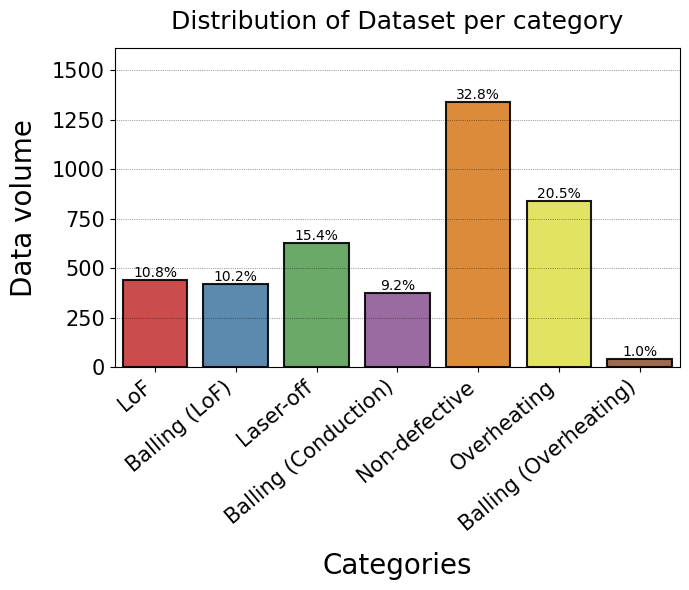

In [27]:
plot_data_distribution(final_annotations_df, 'label_1', 
                       'Distribution of Dataset per category', 'dataset_distribution-final')

In [28]:
# Saving the DataFrame to a CSV file
final_annotations_df.to_csv('dataset_annotations.csv', index=False)